# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal
import set_rc_params as set_rc


%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']
reload(dt)
reload(set_rc)

# Global params
set_rc.set_rc_params()
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_ctrl = (-.9, -.45)
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'Str')

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                         rel_start=int(WINDOW_ctrl[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_ctrl[1]/BIN_SIZE)
                                        )

In [2]:
def prep_general_mouse (df):
    "preprocessing general! for J. Dudman mouse data"
    # rename unit fields
    old_fields = [col for col in df.columns.values if 'unit' in col]
    new_fields = ['M1_spikes' if 'Ctx' in col else 'Str_spikes' for col in old_fields]
    df_ = df.rename(columns = {old:new for old,new in zip(old_fields,new_fields)})
    # change spikes datatype
    for signal in new_fields:
        df_[signal] = [np.nan_to_num(x=s.toarray().T, nan=0) for s in df_[signal]]
    # fill no-laser trials (and index fields) with zero
    n_bins = df_[new_fields[0]][0].shape[0]
    var_len_fields = [ 'spkPullIdx', 'spkRchIdx', 'spkTimeBlaserI']
    fill_zeros = lambda a: a if len(a)>1 else np.zeros((n_bins,))
    for field in var_len_fields:
        if field not in df_.columns:continue
        df_[field] = [fill_zeros(s ) for s in df_[field]]
    # add bin_size
    df_['bin_size']=0.01  # data has 10ms bin size
    # add trial_id
    df_['trial_id'] = np.arange(1,df.shape[0]+1)
    # add idx_movement_on which is exactly at t=df.timeAlign
    df_['idx_movement_on'] = [np.argmin(np.abs(s-i)) for i,s in zip(df_['timeAlign'],df_['spkTimeBins'])]
    # add target_id
    df_['target_id'] = np.remainder(df_['blNumber'].to_numpy(), 4)

    for signal in new_fields:
        df_ = pyal.remove_low_firing_neurons(df_, signal, 1)
    
    df_= pyal.select_trials(df_, df_.trialType== 'sp')
    try:
        noLaserIndex = [i for i,laserData in enumerate(df_.spkTimeBlaserI) if not np.any(laserData)]
        df_= pyal.select_trials(df_, noLaserIndex)
    except AttributeError:
        # due to absence of this field in no-laser sessions
        pass
    
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in new_fields:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_

# reading data

In [3]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
#     df = prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

# Tests on a single session

In [43]:
df = AllDFs[3]
df = pyal.select_trials(df, df.trialType== 'sp');
df['target_id'] = np.remainder(df['blNumber'].to_numpy(), 4)

0
87


Text(0.5, 1.0, 'left and right targets')

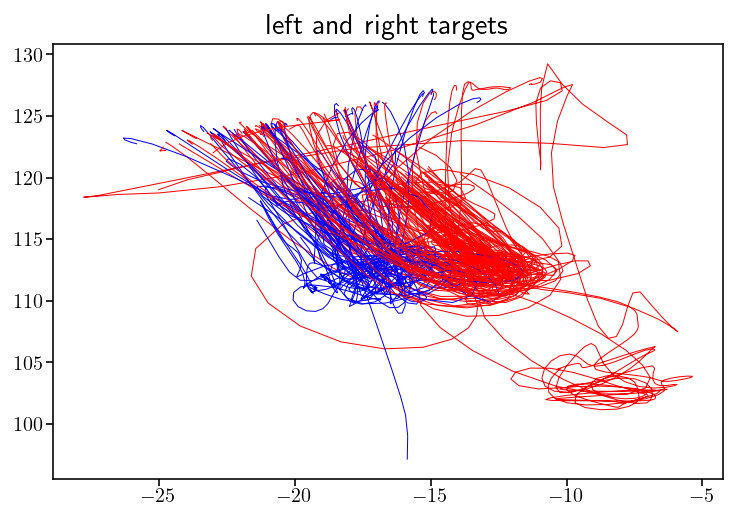

In [51]:
for i,traj in enumerate(df.hTrjB):
    if traj.ndim<2:
        print(i)
        continue
    if df.target_id[i] in (1,2): 
        color = 'r'
    else:
        color = 'b'
    plt.plot(traj.T[100:,0],traj.T[100:,1],lw=.5, color=color)
plt.title('left and right targets')